# Ojective
**To classify a given new review using K-nearest neighbours technique.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
import os 
df=pd.read_csv("/home/gurnatham_ravi/SVM/yesterday/data.csv") 
print("columns are ",df.columns)

columns are  Index(['Unnamed: 0', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'Class'],
      dtype='object')


**For this assignment I took 100k points which are splitted based in the time and among 100k points I chosen 67k points for training and 33k points for testing the performance tof the model.**

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
df_train_x,df_test_x,df_train_y,df_test_y=train_test_split(df['Text'],df['Class'],test_size=0.33,shuffle=False)
print(df_train_x.shape,df_test_x.shape,df_train_y.shape,df_test_y.shape)

(67000,) (33000,) (67000,) (33000,)


# Data standardization function

In [5]:
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler
from sklearn import warnings
warnings.filterwarnings("ignore", category=DataConversionWarning)
def data_standardization(train_data,test_data):
    std=StandardScaler(with_mean=False)
    std=std.fit(train_data)
    train_data = train_data.astype(float)
    test_data = test_data.astype(float)
    train=std.transform(train_data)
    test=std.transform(test_data)
    print(train.shape,test.shape)
    return train,test

# Label encoder

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
bin=preprocessing.LabelEncoder()
df_train_y=bin.fit_transform(df_train_y)
df_test_y=bin.fit_transform(df_test_y)

# truncated_svd

In [24]:
from sklearn.decomposition import TruncatedSVD
def truncated_svd(BOW1_train_std,BOW1_test_std):
  svd = TruncatedSVD(n_components=300)
  svd_func=svd.fit(BOW1_train_std)
  train_data=svd_func.transform(BOW1_train_std)
  test_data=svd_func.transform(BOW1_test_std)
  return train_data,test_data

# Kd_tree function


In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
def kd_tree_function(train_data,df_train_y,filename):
  k_values=[]
  cv_scores=[]
  for i in range(1,31,2):
    knn=KNeighborsClassifier(n_neighbors=i, weights='uniform', algorithm='kd_tree', leaf_size=30,  n_jobs=-1)
    scores=cross_val_score(knn,train_data,df_train_y,cv=3,scoring="f1")
    cv_scores.append(scores)
    k_values.append(i)
    print("done with ",i)
  dataframe=pd.DataFrame({'cv_scores':cv_scores,'k':k_values})
  print(filename)
  #file_path='/content/drive/My Drive/Colab_Notebooks/knn_redoing/'+filename
  dataframe.to_csv(filename)

# Brute force knn

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
def brute_function(train_data,df_train_y,filename):
  k_values=[]
  cv_scores=[]
  for i in range(1,31,2):
    knn=KNeighborsClassifier(n_neighbors=i, weights='uniform', algorithm='brute', leaf_size=30)
    scores=cross_val_score(knn,train_data,df_train_y,cv=3,scoring="f1")
    cv_scores.append(scores)
    k_values.append(i)
    print("done with ",i)
  dataframe=pd.DataFrame({'cv_scores':cv_scores,'k':k_values})
  print(filename)
  #file_path='/content/drive/My Drive/Colab_Notebooks/knn_redoing/'+filename
  dataframe.to_csv(filename)

# conversion 

In [10]:
import ast
import re
def convertion(kd_tree,brute_force):
  tree=[]
  for x in kd_tree['cv_scores']:
    temp=''
    x=re.sub(' +',' ',x)
    for y in x.split(' '):
      temp=temp+y+','
    tree.append(ast.literal_eval(temp))
   
  brute=[]
  for x in brute_force['cv_scores']:
    temp=''
    x=re.sub(' +',' ',x)
    for y in x.split(' '):
      temp=temp+y+','
    brute.append(ast.literal_eval(temp))

  tree=np.array(tree)
  brute=np.array(brute)
  return tree,brute

# plot graph

In [28]:
def plot_graph(tree,brute,t,b,width=0.01):
  x=[]
  x1=[]
  for i in range(0,15):
    x.append(np.mean(brute[i]))
    x1.append(np.mean(tree[i]))
  max_brute=x[b];max_tree=x1[t]
  fig=plt.figure(figsize=(10,5))
  ax1 = fig.add_subplot(211)
  ax1.grid(True)
  ax1.plot(range(1,31,2),x,'r')
  ax1.set_title('brute',fontsize="15", color="red")
  ax1.set_xticks(range(1,30,2))
  ax1.set_ylabel("F1-Score")
  ax1.set_xlabel('K')
  ax1.annotate('maximum value at k='+str(b), xy=(b, max_brute), xytext=(b, max_brute-width),arrowprops=dict(facecolor='red', shrink=0.05),)
  ax2 = fig.add_subplot(212)
  ax2.grid(True)
  ax2.set_xlabel('K')
  ax2.set_ylabel("F1-Score")
  ax2.set_xticks(range(1,30,2))
  ax2.plot(range(1,31,2),x1,'g')
  ax2.annotate('maximum value at k='+str(t), xy=(t, max_tree), xytext=(t,max_tree-width),arrowprops=dict(facecolor='red', shrink=0.05),)
  ax2.set_title('kd_tree', color="red",y=1.08)
  plt.show()
  

# plot confusion matrix

In [19]:
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,accuracy_score
def plot_confusion_matrix(output,df_test_y,name):
  import seaborn as sns
  from beautifultable import BeautifulTable
  table=BeautifulTable()
  table.insert_column(0,"precision_score",[precision_score(df_test_y,output)])
  table.insert_column(1,"recall_score",[recall_score(df_test_y,output)])
  table.insert_column(2,"accuracy",[accuracy_score(df_test_y,output)])
  table.insert_column(3,"f1-score",[f1_score(df_test_y,output)])
  print(table)
  cm_df = pd.DataFrame(confusion_matrix(df_test_y,output),index = ['negative','positive'], columns = ['negative','positive'])
  plt.figure(figsize=(5.5,4))
  sns.heatmap(cm_df, annot=True, fmt='g')
  plt.title('confusion matrix'+name)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()



# BOW-Unigrams

In [13]:
bow_unigrams=CountVectorizer(stop_words='english')
BOW1_train=bow_unigrams.fit(df_train_x)
BOW1_train=bow_unigrams.transform(df_train_x)
BOW1_test=bow_unigrams.transform(df_test_x)
print("The train data shape is ",BOW1_train.shape,"and test data shape is ",BOW1_test.shape)

The train data shape is  (67000, 90770) and test data shape is  (33000, 90770)


In [14]:
train,test=data_standardization(BOW1_train,BOW1_test)

(67000, 90770) (33000, 90770)


In [39]:
train_data,test_data=truncated_svd(train,test)
print(train_data.shape,test_data.shape)

(67000, 300) (33000, 300)


In [0]:
kd_tree_function(train_data[:40000],df_train_y[:40000],'bow_unigarms_kd_tree.csv')

In [0]:
brute_function(train,df_train_y,'bow_unigarms_brute.csv')

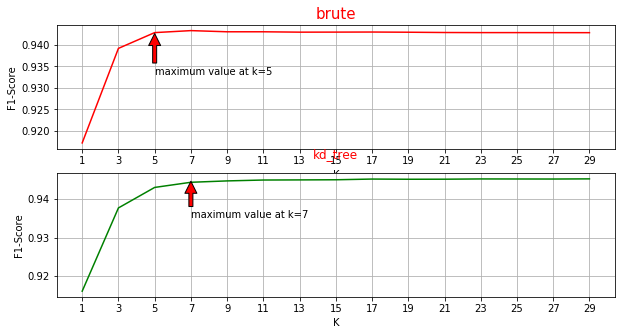

In [14]:
kd_tree=pd.read_csv('bow_unigarms_kd_tree.csv')
brute=pd.read_csv('bow_unigarms_brute.csv')
tree,brute=convertion(kd_tree,brute)
plot_graph(tree,brute,7,5)

**1. In the kd-tree at k=7 we are getting high accuracy **<br>
    **2. In brute technique , at k=5 , we are getting high accuracy around 94.28% **

In [40]:
knn=KNeighborsClassifier(n_neighbors=7,algorithm="kd_tree",n_jobs=-1,leaf_size=30)
knn_classifier=knn.fit(train_data[:40000],df_train_y[:40000])

In [42]:
kd_tree_output=knn_classifier.predict(test_data)

+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.877      |    0.996     |  0.874   |  0.933   |
+-----------------+--------------+----------+----------+


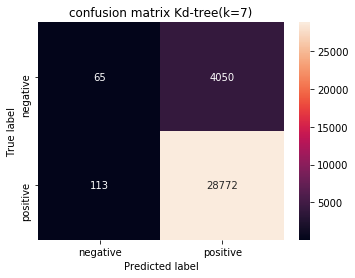

In [54]:
plot_confusion_matrix(kd_tree_output,df_test_y," Kd-tree(k=7)")

In [49]:
knn=KNeighborsClassifier(n_neighbors=5,algorithm="brute",n_jobs=-1)
knn_classifier=knn.fit(train,df_train_y)

In [51]:
brute_output=knn_classifier.predict(test)

+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.88       |    0.995     |  0.876   |  0.934   |
+-----------------+--------------+----------+----------+


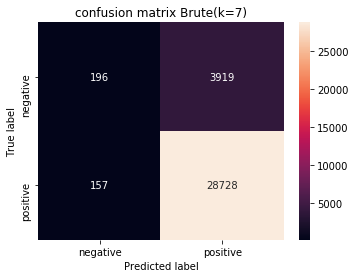

In [55]:
plot_confusion_matrix(brute_output,df_test_y,' Brute(k=7)')

# observation
1.**In kd-tree, Precision score 87.7% which indicates that among the total reviews which are labled as positive, 87.6% are atually positive and recall score is 99% which means from total positive reviews in test data, model identifed correctly 99% of them as positive. **

2.**In brute-force method, Precision score 88% which indicates that among the total reviews which are labled as positive, 88% are atually positive and recall score is 99.5% which means from total positive reviews in test data, model identifed correctly 99.5% of them as positive. **



# BOW- Bigrams

In [12]:
bow_unigrams=CountVectorizer(ngram_range=(1,2),stop_words='english')
BOW1_train=bow_unigrams.fit(df_train_x)
BOW1_train=bow_unigrams.transform(df_train_x)
BOW1_test=bow_unigrams.transform(df_test_x)
print("The train data shape is ",BOW1_train.shape,"and test data shape is ",BOW1_test.shape)

The train data shape is  (67000, 1169770) and test data shape is  (33000, 1169770)


In [13]:
train,test=data_standardization(BOW1_train,BOW1_test)

(67000, 1169770) (33000, 1169770)


In [14]:
train_data,test_data=truncated_svd(train,test)
print(train_data.shape,test_data.shape)

(67000, 300) (33000, 300)


In [0]:
kd_tree_function(train_data[:40000],df_train_y[:40000],'bow_Bigarms_kd_tree.csv')

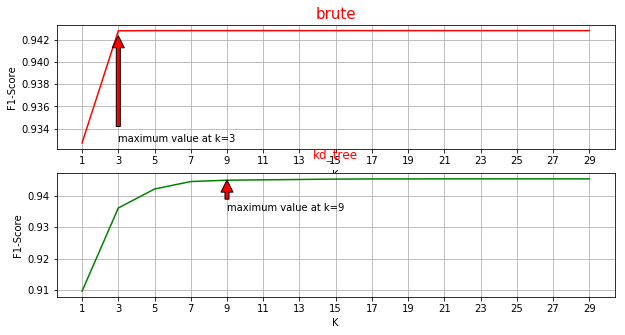

In [15]:
kd_tree=pd.read_csv('bow_Bigarms_kd_tree.csv')
brute=pd.read_csv('bow_Bigarms_brute.csv')
tree,brute=convertion(kd_tree,brute)
plot_graph(tree,brute,9,3)

**1. In the kd-tree at k=9 we are getting high accuracy **<br>
    **2. In brute technique , at k=3 , we are getting high accuracy around 94.3% **

In [17]:
knn=KNeighborsClassifier(n_neighbors=9,algorithm="kd_tree",n_jobs=-1,leaf_size=30)
knn_classifier=knn.fit(train_data[:40000],df_train_y[:40000])

In [18]:
kd_tree_output=knn_classifier.predict(test_data)

+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.876      |    0.997     |  0.873   |  0.932   |
+-----------------+--------------+----------+----------+


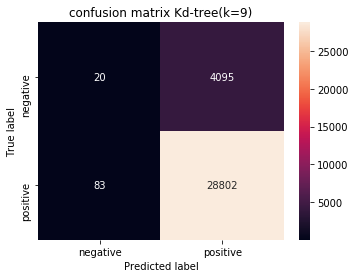

In [19]:
plot_confusion_matrix(kd_tree_output,df_test_y," Kd-tree(k=9)")

In [20]:
knn=KNeighborsClassifier(n_neighbors=3,algorithm="brute",n_jobs=-1)
knn_classifier=knn.fit(train,df_train_y)

In [22]:
brute_output=knn_classifier.predict(test)

+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.875      |     1.0      |  0.875   |  0.933   |
+-----------------+--------------+----------+----------+


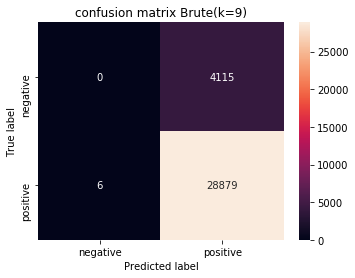

In [23]:
plot_confusion_matrix(brute_output,df_test_y," Brute(k=9)")

# observation
1.**In kd-tree, Precision score 87.6% which indicates that among the total reviews which are labled as positive, 87.6% are atually positive and recall score is 99.7% which means from total positive reviews in test data, model identifed correctly 99.7% of them as positive. **

2.**In brute-force method, Precision score 87.5% which indicates that among the total reviews which are labled as positive, 87.5% are atually positive and recall score is 100% which means from total positive reviews in test data, model identifed correctly 100% of them as positive. **



# TF_IDF unigrams

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
bow_unigrams=TfidfVectorizer(stop_words='english')
BOW1_train=bow_unigrams.fit(df_train_x)
BOW1_train=bow_unigrams.transform(df_train_x)
BOW1_test=bow_unigrams.transform(df_test_x)
print("The train data shape is ",BOW1_train.shape,"and test data shape is ",BOW1_test.shape)

The train data shape is  (67000, 90770) and test data shape is  (33000, 90770)


In [13]:
train,test=data_standardization(BOW1_train,BOW1_test)

(67000, 90770) (33000, 90770)


In [14]:
train_data,test_data=truncated_svd(train,test)
print(train_data.shape,test_data.shape)

(67000, 300) (33000, 300)


In [0]:
kd_tree_function(train_data[:40000],df_train_y[:40000],'tfidf_unigarms_kd_tree.csv')

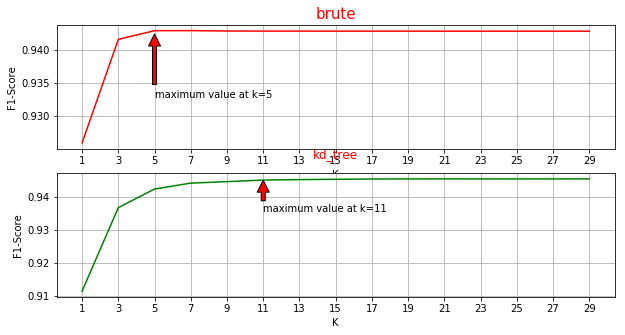

In [16]:
kd_tree=pd.read_csv('tfidf_unigarms_kd_tree.csv')
brute=pd.read_csv('tfidf_unigarms_brute.csv')
tree,brute=convertion(kd_tree,brute)
plot_graph(tree,brute,11,5)

**1. In the kd-tree at k=11 we are getting high accuracy **<br>
    **2. In brute technique , at k=5 , we are getting high accuracy around 94.5% **

In [15]:
knn=KNeighborsClassifier(n_neighbors=11,algorithm="kd_tree",n_jobs=-1,leaf_size=30)
knn_classifier=knn.fit(train_data[:40000],df_train_y[:40000])

In [16]:
kd_tree_output=knn_classifier.predict(test_data)

+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.876      |    0.999     |  0.875   |  0.933   |
+-----------------+--------------+----------+----------+


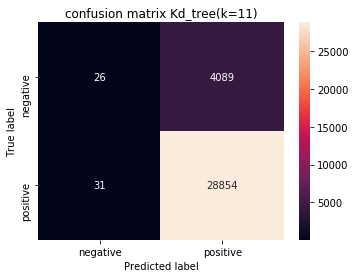

In [17]:
plot_confusion_matrix(kd_tree_output,df_test_y," Kd_tree(k=11)")

In [18]:
knn=KNeighborsClassifier(n_neighbors=5,algorithm="brute",n_jobs=-1)
knn_classifier=knn.fit(train,df_train_y)

In [19]:
brute_output=knn_classifier.predict(test)

+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.877      |    0.998     |  0.875   |  0.933   |
+-----------------+--------------+----------+----------+


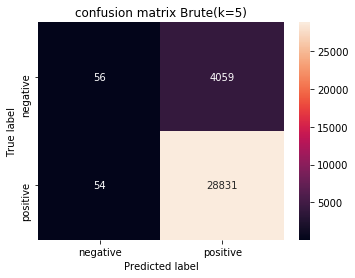

In [21]:
plot_confusion_matrix(brute_output,df_test_y," Brute(k=5)")

# observation
1.**In kd-tree, Precision score 87.6% which indicates that among the total reviews which are labled as positive, 87.6% are atually positive and recall score is 99.9% which means from total positive reviews in test data, model identifed correctly 99.9% of them as positive. **

2.**In brute-force method, Precision score 87.7% which indicates that among the total reviews which are labled as positive, 87.7% are atually positive and recall score is 99.8% which means from total positive reviews in test data, model identifed correctly 99.8% of them as positive. **



# TF_IDF Bigrams

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
bow_unigrams=TfidfVectorizer(ngram_range=(1,2),stop_words='english')
BOW1_train=bow_unigrams.fit(df_train_x)
BOW1_train=bow_unigrams.transform(df_train_x)
BOW1_test=bow_unigrams.transform(df_test_x)
print("The train data shape is ",BOW1_train.shape,"and test data shape is ",BOW1_test.shape)

The train data shape is  (67000, 1169770) and test data shape is  (33000, 1169770)


In [23]:
train,test=data_standardization(BOW1_train,BOW1_test)

(67000, 1169770) (33000, 1169770)


In [24]:
train_data,test_data=truncated_svd(train,test)
print(train_data.shape,test_data.shape)

(67000, 300) (33000, 300)


In [0]:
kd_tree_function(train_data[:40000],df_train_y[:40000],'tfidf_bigarms_kd_tree.csv')

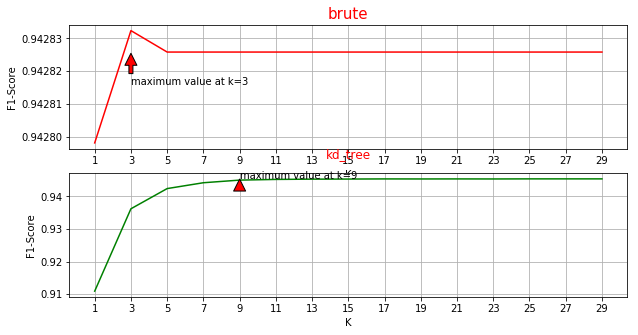

In [17]:
kd_tree=pd.read_csv('tfidf_bigarms_kd_tree.csv')
brute=pd.read_csv('tfidf_Bigarms_brute.csv')
tree,brute=convertion(kd_tree,brute)
plot_graph(tree,brute,9,3,width=0.00001)

**1. In the kd-tree at k=9 we are getting high accuracy **<br>
    **2. In brute technique , at k=3 , we are getting high accuracy around 94.5% **

In [25]:
knn=KNeighborsClassifier(n_neighbors=9,algorithm="kd_tree",n_jobs=-1,leaf_size=30)
knn_classifier=knn.fit(train_data[:40000],df_train_y[:40000])

In [26]:
kd_tree_output=knn_classifier.predict(test_data)

+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.875      |    0.997     |  0.873   |  0.932   |
+-----------------+--------------+----------+----------+


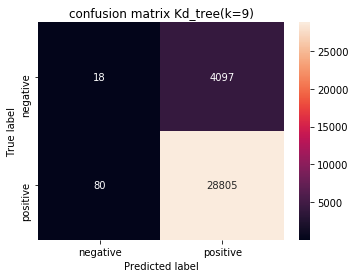

In [27]:
plot_confusion_matrix(kd_tree_output,df_test_y," Kd_tree(k=9)")

In [28]:
knn=KNeighborsClassifier(n_neighbors=3,algorithm="brute",n_jobs=-1)
knn_classifier=knn.fit(train,df_train_y)

In [30]:
brute_output=knn_classifier.predict(test)

+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.875      |     1.0      |  0.875   |  0.934   |
+-----------------+--------------+----------+----------+


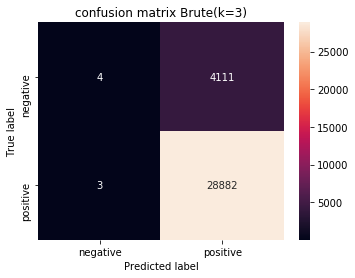

In [31]:
plot_confusion_matrix(brute_output,df_test_y," Brute(k=3)")

# observation
1.**In kd-tree, Precision score 87.5% which indicates that among the total reviews which are labled as positive, 87.5% are atually positive and recall score is 99.7% which means from total positive reviews in test data, model identifed correctly 99.7% of them as positive. **

2.**In brute-force method, Precision score 87.5% which indicates that among the total reviews which are labled as positive, 87.5% are atually positive and recall score is 100% which means from total positive reviews in test data, model identifed correctly 100% of them as positive. **



# word2vec model

In [32]:
!python -V
model=[]
for sent in df_train_x:
    temp=[]
    for word in sent.split():
        temp.append(word)
    model.append(temp)
model[0][:8]

Python 3.6.5 :: Anaconda, Inc.


['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh']

In [33]:
from gensim.models import Word2Vec
amazon_model = Word2Vec(model, size=100, window=5, min_count=1, workers=4)

/home/gurnatham_ravi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/gurnatham_ravi/anaconda3/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [34]:
import numpy as np
word_vectors = amazon_model.wv
train_vec=[]
counter=0
for sentence in df_train_x:
    temp=np.zeros(100)
    length=0
    for word in sentence.split():
        if word in word_vectors:
            temp=temp+amazon_model.wv[word]
        else:
            print(word," is not presnet in training model of word2vec")
    length+=1
    train_vec.append(temp/length)
    if(counter%10000==0):
        print(counter)
    counter+=1

0
10000
20000
30000
40000
50000
60000


In [35]:
import numpy as np
word_vectors = amazon_model.wv
test_vec=[]
counter=0
for sentence in df_test_x:
    temp=np.zeros(100)
    length=0
    for word in sentence.split():
        if word in word_vectors:
            temp=temp+amazon_model.wv[word]
        #else:
         #   print(word," is not presnet in training model of word2vec")
    length+=1
    test_vec.append(temp/length)
    if(counter%10000==0):
        print(counter)
    counter+=1

0
10000
20000
30000


In [37]:
train,test=data_standardization(np.array(train_vec),np.array(test_vec))

(67000, 100) (33000, 100)


In [0]:
kd_tree_function(train[:40000],df_train_y[:40000],'tfidf_bigarms_kd_tree.csv')

In [0]:
brute_function(train,df_train_y,'word2vec_brute.csv')

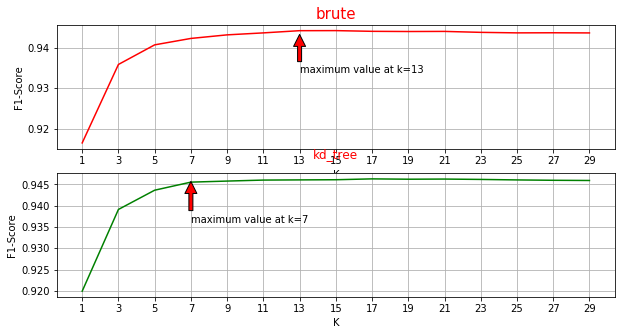

In [18]:
kd_tree=pd.read_csv('word2vec_kd_tree.csv')
brute=pd.read_csv('word2vec_brute.csv')
tree,brute=convertion(kd_tree,brute)
plot_graph(tree,brute,7,13)

**1. In the kd-tree at k=7 we are getting high accuracy **<br>
    **2. In brute technique , at k=13 , we are getting high accuracy around 95% **

In [48]:
knn=KNeighborsClassifier(n_neighbors=7,algorithm="kd_tree",n_jobs=-1,leaf_size=30)
knn_classifier=knn.fit(train[:40000],df_train_y[:40000])

In [49]:
kd_tree_output=knn_classifier.predict(test)

+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.887      |    0.984     |  0.877   |  0.933   |
+-----------------+--------------+----------+----------+


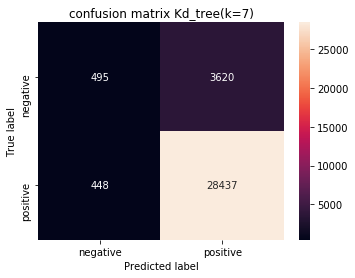

In [50]:
plot_confusion_matrix(kd_tree_output,df_test_y," Kd_tree(k=7)")

In [51]:
knn=KNeighborsClassifier(n_neighbors=13,algorithm="brute",n_jobs=-1)
knn_classifier=knn.fit(train,df_train_y)

In [54]:
brute_output=knn_classifier.predict(test)

+-----------------+--------------+----------+----------+
| precision_score | recall_score | accuracy | f1-score |
+-----------------+--------------+----------+----------+
|      0.885      |    0.992     |   0.88   |  0.935   |
+-----------------+--------------+----------+----------+


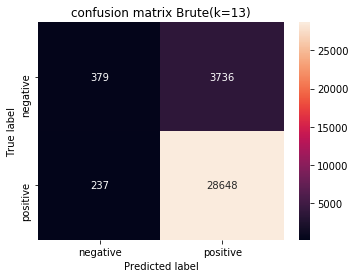

In [55]:
plot_confusion_matrix(brute_output,df_test_y," Brute(k=13)")

# observation
1.**In kd-tree, Precision score 88.7% which indicates that among the total reviews which are labled as positive, 88.7% are atually positive and recall score is 98.4% which means from total positive reviews in test data, model identifed correctly 98.4% of them as positive. **

2.**In brute-force method, Precision score 88.5% which indicates that among the total reviews which are labled as positive, 88.5% are atually positive and recall score is 99.2% which means from total positive reviews in test data, model identifed correctly 99.2% of them as positive. **



# Conclusion 

In [23]:
from beautifultable import BeautifulTable
table=BeautifulTable()
model_names=["BOW_Unigrams","BOW_Unigrams","BOW_Bigrams","BOW_Bigrams","TF_IDF_Unigrams","TF_IDF_Unigrams","TF_IDF_Bigrams","TF_IDF_Bigrams","Word2vec","Word2vec"]
type_model=["kd_tree","brute","kd_tree","brute","kd_tree","brute","kd_tree","brute","kd_tree","brute"]
k=[7,5,9,3,11,5,9,3,7,13]
cv_accuracy=[94.3,94.5,94.6,94.25,94.6,94.8,94.6,94.2834,94.5,94.8]
f1_scores=[93.33,93.4,93.2,93.33,93.33,93.33,93.2,93.4,93.3,93.5]
table.insert_column(0,"model",model_names)
table.insert_column(1,"type",type_model)
table.insert_column(2,"K",k)
table.insert_column(3,"CV-accuracy",cv_accuracy)
table.insert_column(4,"accuracy(f1-score)",f1_scores)
print(table)

+----------------------+---------+----+-------------+--------------------------+
|        model         |  type   | K  | CV-accuracy |    accuracy(f1-score)    |
+----------------------+---------+----+-------------+--------------------------+
|     BOW_Unigrams     | kd_tree | 7  |    94.3     |          93.33           |
+----------------------+---------+----+-------------+--------------------------+
|     BOW_Unigrams     |  brute  | 5  |    94.5     |           93.4           |
+----------------------+---------+----+-------------+--------------------------+
|     BOW_Bigrams      | kd_tree | 9  |    94.6     |           93.2           |
+----------------------+---------+----+-------------+--------------------------+
|     BOW_Bigrams      |  brute  | 3  |    94.25    |          93.33           |
+----------------------+---------+----+-------------+--------------------------+
|   TF_IDF_Unigrams    | kd_tree | 11 |    94.6     |          93.33           |
+----------------------+----


**In this assignment  I took 100k points for brute force model and 40k points for the kd-tree model  and used bow and tf_idf vectorizations,word2vec and analyzed for both the brute force and kd tree approaches and the kd-tree with 40k points performs as good as the brute force method with 100k points. And each vectorization is performing well and each model f1-score is above 90% **